# Sheet 3 - Exercise 4

## Instructions To Run This Notebook

### On your local machine (Assuming MacOS or Linux based distribution)

1. Create a folder: `mkdir sheet3`
2. Go to the folder `cd sheet3`
3. Install all the necessary dependencies (we assume you already have python and pip) by running the following command:
    `pip install pyspark pandas matplotlib numpy scikit-learn`
4. Download the files **After_Pre_Processing.xlsx** and **Before_Pre_Processing.xlsx** from moodle if you don't have them
5. Put the **After_Pre_Processing.xlsx** and **Before_Pre_Processing.xlsx** in the folder **sheet3** you have just created
6. Put this notebook **sheet3_exercise4.ipynb** in the same folder **sheet3**
7. Make sure the image **metrics.png** is also in the same folder
8. Now you can run this notebook on *Jupyter* or *VSCode* by clicking "Run All"

### On HPC 

To run this notebook on HPC you will first need to setup Jupyter on HPC by following these steps:

1. Log into your HPC instance by using the command: `ssh -p 8022 <your-login>@access-iris.uni.lu` (replace your-login with your HPC login)
2. Once logged in, initialize a session using `si`
3. Create a directory inside HPC: `mkdir sheet3`
4. Go to the directory: `cd sheet3`
5. Load python: `module load lang/Python`
6. Create a Python environment for this activity: `python -m venv jupyter_env`
7. Activate the environment: `source jupyter_env/bin/activate`
8. Install/Upgrade pip: `python -m pip install --upgrade pip`
9. Install Jupyter: `python -m pip install jupyter ipykernel`
10. Install all the required dependencies: `pip install pyspark pandas matplotlib numpy scikit-learn`
11. Register our environment to the Jupyter kernel: `python -m ipykernel install --sys-prefix --name jupyter_env`
12. Run the following command to launch a jupyter server on HPC: `jupyter notebook --no-browser --port=8888 --NotebookApp.token='' --NotebookApp.password='' -NotebookApp.disable_check_xsrf=True --ip=0.0.0.0`


Now go on your local machine, open a new terminal tab and do the following:
1. Copy files from local to HPC, on your local machine within the directory where you have the .ipynb and .xlsx files stored run the following commands:
`scp -P 8022 sheet3_exercise4.ipynb <your-login>@access-iris.uni.lu:~/sheet3`
`scp -P 8022 After_Pre_Processing.xlsx <your-login>@access-iris.uni.lu:~/sheet3`
`scp -P 8022 Before_Pre_Processing.xlsx <your-login>@access-iris.uni.lu:~/sheet3`
2. Launch the jupyter notebook on localhost by running: `ssh -p 8022 -NL 8888:iris-XXX:8888 <your-login>@access-iris.uni.lu` and replace XXX by the number of the iris cluster provided to you on HPC for example I have on HPC *(jupyter_env) 0 [omahfoud@iris-055 sheet3](3487277 1N/T/1CN)$* so I would replace XXX by *055*
3. On your machine open your favorite browser and go to `localhost:8888` or `http://127.0.0.1:8888/` this should open your Jupyter interface
4. Click on **sheet3_exercise4.ipynb** then click on **Run All*

## Performance Measures for Multiclass Classification based on Paper

After carefuly reading the paper Sokolova, M., Lapalme, G. (2009). A systematic analysis of performance measures for classification tasks. Information Processing and Management, 45, p. 427-437. I have seen that in page 430 the author summarizes in Table 3 Measures for multi-class classification based on a generalization of the measures of Table 1 (Confusion matrix for binary classification and the corresponding array representation used in this paper.) for many classes <br>
Ci: tpi are true positive for Ci, and fpi – false positive, fni – false negative, and tni – true negative counts respectively. <br>
l and M indices represent micro- and macro-averaging. <br>
The table in metrics.png (shown below) summarize the metrics aforementionned.

![image info](metrics.png)

## Redefine all the previously implemented metrics in Exercise 2

Below we will review the Classification section of exercise 2 while defining new metrics based on the paper

### Module Imports and Data Acquisition

In [107]:
!pip install pyspark pandas matplotlib numpy scikit-learn

In [108]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import warnings
import matplotlib.pyplot as plt
import numpy as np


# Initializing a spark session
spark = SparkSession.builder.appName("sheet3_exercise2").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

warnings.filterwarnings('ignore')

In [109]:
# Reading excel data to a spark RDD
raw_data = pd.read_excel("After_Pre_Processing.xlsx")
spark_df = spark.createDataFrame(raw_data)
spark_df.show()

+-------+--------+-----+---------+-------------------+---------+---------+---------+---------+--------------------+--------------------+------+------+-------------------+--------------+--------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+-------

In [110]:
# Removing the "USER" column
spark_df = spark_df.drop('USER')

We notice that reducing the number of features and selecting only the most important ones has increased our error, therefore in our case fr this regression it was not useful

### Decision Tree Classifier for Categorical Variable

### Imports

In [53]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Create the dataframe from our data and follow the same steps as above 

In [54]:
spark_df = spark.createDataFrame(raw_data)

In [55]:
spark_df = spark_df.drop('USER')

In [56]:
target = 'S1Q061nor'

In [57]:
spark_df = spark_df.withColumn(target, col(target) * 2)

In [58]:
def fill_missing_values(df):
    for column in df.columns:
        if df.schema[column].dataType == "DoubleType":
            mean_value = df.select(col(column)).na.drop().groupBy().avg(column).first()[0]
            df = df.fillna(mean_value, subset=[column])
        else:
            mode_value = df.groupBy(column).count().orderBy('count', ascending=False).first()[0]
            df = df.fillna(mode_value, subset=[column])
    return df

In [59]:
spark_df = fill_missing_values(spark_df)

In [60]:
for column in spark_df.columns:
    if spark_df.schema[column].dataType == "StringType":
        spark_df = spark_df.withColumn(column, when(col(column).isNull(), "").otherwise(col(column)))

### Define indexers and assembler

In [61]:
indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed").fit(spark_df)
            for column in spark_df.columns if spark_df.schema[column].dataType == "StringType"]

In [62]:
assembler = VectorAssembler(inputCols=[col + "_indexed" if col + "_indexed" in spark_df.columns else col for col in spark_df.columns if col != target],
                            outputCol="features")

### Create pre-processing pipeline

In [63]:
pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(spark_df)
preprocessed_df = pipeline_model.transform(spark_df)

In [64]:
preprocessed_df.show()

+--------+-----+---------+-------------------+---------+---------+---------+---------+--------------------+--------------------+------+------+-------------------+--------------+--------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+---------------

### Train and evaluate a decision tree classifier model

In [65]:
# Calculate metrics
def calculate_multiclass_metrics(confusion_matrix):
    TP = np.diag(confusion_matrix)
    FP = np.sum(confusion_matrix, axis=0) - TP
    FN = np.sum(confusion_matrix, axis=1) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)

    # Accuracy
    accuracy = np.sum(TP) / np.sum(confusion_matrix)

    # Precision, Recall, F1-Score for each class
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Macro-averaged metrics
    precision_macro = np.nanmean(precision)
    recall_macro = np.nanmean(recall)
    f1_score_macro = np.nanmean(f1_score)

    return accuracy, precision_macro, recall_macro, f1_score_macro

In [66]:
def train_and_evaluate(spark_df, target):
    (train_data, test_data) = spark_df.randomSplit([0.7, 0.3], seed=42)

    dt = DecisionTreeClassifier(labelCol=target, featuresCol="features")

    model = dt.fit(train_data)

    predictions = model.transform(test_data)

    # Collect labels and predictions
    labels_and_preds = predictions.select(target, "prediction").collect()
    labels = [row[target] for row in labels_and_preds]
    preds = [row['prediction'] for row in labels_and_preds]
    labels = np.array(labels)
    preds = np.array(preds)
    
    # Calculate confusion matrix
    classes = np.unique(labels)
    confusion_matrix = np.zeros((len(classes), len(classes)))
    for i, j in zip(labels, preds):
        confusion_matrix[int(i)][int(j)] += 1
    
    # metrics are calculated using their mathematical formulas as discussed in the paper.
    accuracy, precision_macro, recall_macro, f1_score_macro = calculate_multiclass_metrics(confusion_matrix)
    
    metrics = {
        "accuracy": accuracy,
        "precision": precision_macro,
        "recall": recall_macro,
        "f1": f1_score_macro
    }
    print(f"Evaluation metrics for {target}:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {round(value, 4)}")

    return model

In [67]:
model = train_and_evaluate(preprocessed_df, target)

Evaluation metrics for S1Q061nor:
Accuracy: 0.9884
Precision: 0.9937
Recall: 0.9722
F1: 0.9823


### Identify features' importance

In [68]:
feature_names = assembler.getInputCols()

In [69]:
def plot_feature_importance(model, feature_names, target):
    importances = model.featureImportances
    indices = np.argsort(importances)[::-1].tolist()  # Convert indices to a list of integers

    filtered_indices = [idx for idx in indices if importances[idx] > 0.01]
    filtered_importances = [importances[idx] for idx in filtered_indices]
    filtered_feature_names = [feature_names[idx] for idx in filtered_indices]

    plt.figure(figsize=(10, 20)) 
    plt.title(f"Feature importances for {target}")
    plt.barh(range(len(filtered_importances)), filtered_importances, align="center")
    plt.yticks(range(len(filtered_importances)), filtered_feature_names, rotation=0)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

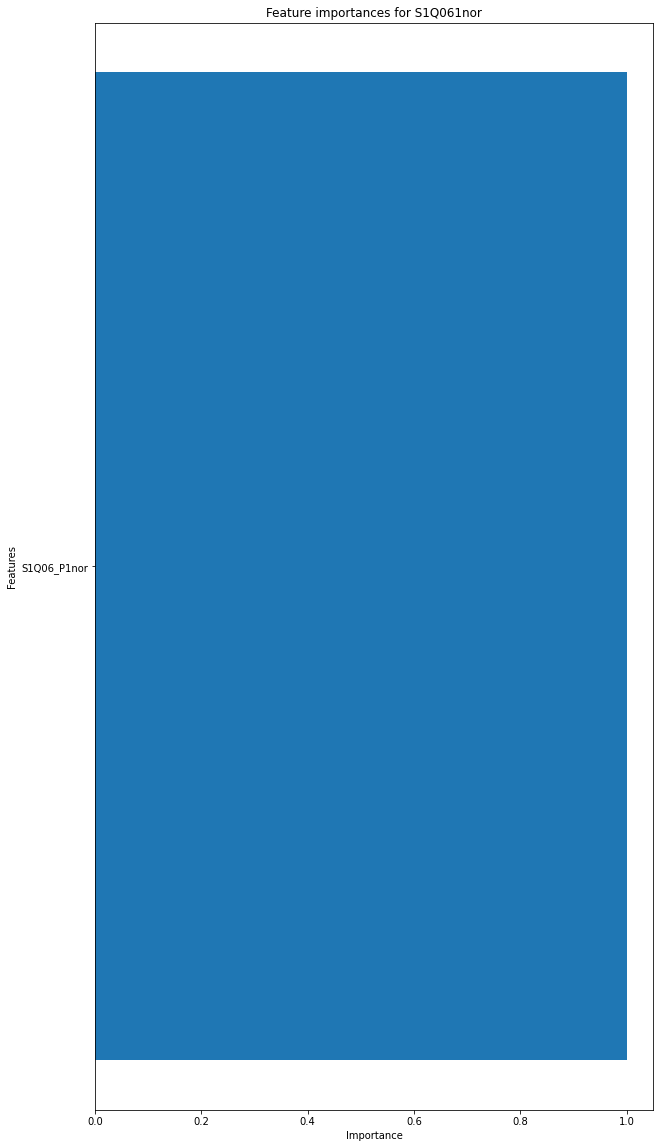

In [70]:
plot_feature_importance(model, feature_names, target)

In [71]:
def select_important_features(model, feature_names, threshold=0.01):
    importances = model.featureImportances
    selected_features = [feature_names[idx] for idx in range(len(importances)) if importances[idx] > threshold]
    return selected_features

In [72]:
selected_features = select_important_features(model, feature_names)
print(f"Selected features: {selected_features}")

Selected features: ['S1Q06_P1nor']


### Retrain the model only with selected features

In [73]:
def retrain_with_selected_features(spark_df, selected_features, target):
    assembler = VectorAssembler(inputCols=selected_features, outputCol="selected_features")

    pipeline = Pipeline(stages=indexers + [assembler])
    pipeline_model = pipeline.fit(spark_df)
    preprocessed_df = pipeline_model.transform(spark_df)

    (train_data, test_data) = preprocessed_df.randomSplit([0.7, 0.3], seed=42)

    dt = DecisionTreeClassifier(labelCol=target, featuresCol="selected_features")

    model = dt.fit(train_data)

    predictions = model.transform(test_data)

    # Collect labels and predictions
    labels_and_preds = predictions.select(target, "prediction").collect()
    labels = [row[target] for row in labels_and_preds]
    preds = [row['prediction'] for row in labels_and_preds]
    labels = np.array(labels)
    preds = np.array(preds)
    
    # Calculate confusion matrix
    classes = np.unique(labels)
    confusion_matrix = np.zeros((len(classes), len(classes)))
    for i, j in zip(labels, preds):
        confusion_matrix[int(i)][int(j)] += 1
    
    # metrics are calculated using their mathematical formulas as discussed in the paper.
    accuracy, precision_macro, recall_macro, f1_score_macro = calculate_multiclass_metrics(confusion_matrix)
    
    metrics = {
        "accuracy": accuracy,
        "precision": precision_macro,
        "recall": recall_macro,
        "f1": f1_score_macro
    }

    print(f"Evaluation metrics for {target}:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {round(value, 4)}")
        
    return model

In [74]:
selected_model = retrain_with_selected_features(spark_df, selected_features, target)

Evaluation metrics for S1Q061nor:
Accuracy: 0.9884
Precision: 0.9937
Recall: 0.9722
F1: 0.9823


### Conclusion

We can see that indeed following this new approach we get different results for the metrics discussed in class for binary classification

## Redefine all the previously implemented metrics in Exercise 3 (Categorical Part)

Please note that we will present the results in table format at the end of the exercise after compiling the results of all the different runs

### Import necessary libraries

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

### Read Excel files containing before and after pre-processing

In [76]:
bpp_df = pd.read_excel('Before_Pre_Processing.xlsx')
app_df = pd.read_excel('After_Pre_Processing.xlsx')

### Define functions to generate multiple iterations of decision trees and print results

In [77]:
# Calculate metrics
def calculate_multiclass_metrics(confusion_matrix):
    TP = np.diag(confusion_matrix)
    FP = np.sum(confusion_matrix, axis=0) - TP
    FN = np.sum(confusion_matrix, axis=1) - TP
    TN = np.sum(confusion_matrix) - (FP + FN + TP)

    # Accuracy
    accuracy = np.sum(TP) / np.sum(confusion_matrix)

    # Precision, Recall, F1-Score for each class
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Macro-averaged metrics
    precision_macro = np.nanmean(precision)
    recall_macro = np.nanmean(recall)
    f1_score_macro = np.nanmean(f1_score)

    return accuracy, precision_macro, recall_macro, f1_score_macro

def generate_decision_trees(X, y):
    accuracy, precision, recall, f1_score  = [], [], [], []

    for _ in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        dt_classifier = DecisionTreeClassifier().fit(X_train, y_train)

        predictions = dt_classifier.predict(X_test)

        # Calculate confusion matrix
        classes = np.unique(y)
        confusion_matrix = np.zeros((len(classes), len(classes)))
        
        for i, j in zip(y_test, predictions):
            confusion_matrix[int(i)][int(j)] += 1

        # metrics are calculated using their mathematical formulas as discussed in the paper.
        acc, prec, rec, f1 = calculate_multiclass_metrics(confusion_matrix)
        
        accuracy.append(acc)
        precision.append(prec)
        recall.append(rec)
        f1_score.append(f1)
    
    return accuracy, precision, recall, f1_score

def print_results(accuracy, precision, recall, f1_score):
    print('Accuracy')
    print('Min: ', min(accuracy))
    print('Max: ', max(accuracy))
    print('Avg: ', np.mean(accuracy))
    print('Std: ', np.std(accuracy), '\n')

    print('Precision')
    print('Min: ', min(precision))
    print('Max: ', max(precision))
    print('Avg: ', np.mean(precision))
    print('Std: ', np.std(precision), '\n')

    print('Recall')
    print('Min: ', min(recall))
    print('Max: ', max(recall))
    print('Avg: ', np.mean(recall))
    print('Std: ', np.std(recall), '\n')

    print('F1 Score')
    print('Min: ', min(f1_score))
    print('Max: ', max(f1_score))
    print('Avg: ', np.mean(f1_score))
    print('Std: ', np.std(f1_score), '\n')


def create_df(predictor_set, dataset, target, accuracy, precision, recall, f1_score):

    lst = [
        [predictor_set, dataset, target, "Accuracy", min(accuracy), max(accuracy), np.mean(accuracy), np.std(accuracy)], 
        [predictor_set, dataset, target, "Precision", min(precision), max(precision), np.mean(precision), np.std(precision)], 
        [predictor_set, dataset, target, "Recall", min(recall), max(recall), np.mean(recall), np.std(recall)],
        [predictor_set, dataset, target, "F1-Score", min(f1_score), max(f1_score), np.mean(f1_score), np.std(f1_score)],
    ]

    df = pd.DataFrame(lst, columns=['predictor_set', 'dataset', 'target', 'metric', 'min', 'max', 'avg', 'stddev'])
    return df

dfs = []

### Before-Pre-Processing (b), in which S1Q061 and S1Q06P1 are NOT pre-processed

#### S1Q061

In [78]:
# All features
# Since the data is continuous we have decided to bin the data into 3 separate categories
bpp_df['S1Q061_cat'] = pd.cut(bpp_df['S1Q061'], bins=3, labels=False)

all_cols = bpp_df.columns.drop(['USER', 'S1Q061', 'S1Q061_cat'])
X, y = bpp_df[all_cols].values, bpp_df['S1Q061_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("ALL", "b", 'S1Q061', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.9814814814814815
Max:  1.0
Avg:  0.9950617283950616
Std:  0.008189197013223196 

Precision
Min:  0.9888888888888889
Max:  1.0
Avg:  0.9973493805214235
Std:  0.004414806937844033 

Recall
Min:  0.9444444444444445
Max:  1.0
Avg:  0.9890692640692641
Std:  0.01862246567801867 

F1 Score
Min:  0.9640472521828455
Max:  1.0
Avg:  0.9928145409211139
Std:  0.012190120681441152 



In [79]:
# INVBOOL features
invbool_cols = ['S2Q01_a_201801', 'S1Q05', 'S5Q05_a01', 'S5Q05_a02', 'S5Q05_a03', 'S5Q05_a04', 'S5Q05_a05',	'S5Q05_a06', 'S5Q05_a24', 
                'S5Q05_a07', 'S5Q05_a08', 'S5Q05_a09', 'S5Q05_a10', 'S5Q05_a11', 'S5Q05_a12', 'S5Q05_b13', 'S5Q05_b14', 'S5Q05_b15',
                'S5Q05_b16', 'S5Q05_b17', 'S5Q05_b18', 'S5Q05_b19', 'S5Q05_b20', 'S5Q05_b21',	'S5Q05_b22', 'S4Q011_AL']
X, y = bpp_df[invbool_cols].values, bpp_df['S1Q061_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVBOOL", "b", 'S1Q061', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.3148148148148148
Max:  0.6111111111111112
Avg:  0.4623456790123456
Std:  0.06936964421477877 

Precision
Min:  0.2566583953680728
Max:  0.45137395459976104
Avg:  0.3439604607446538
Std:  0.058819617328342406 

Recall
Min:  0.20614035087719298
Max:  0.5237352737352737
Avg:  0.3388267737981651
Std:  0.07507352074236912 

F1 Score
Min:  0.25460030165912517
Max:  0.4951923076923077
Avg:  0.38980487045385986
Std:  0.059766346000592406 



In [80]:
# INVCONT features
invcont_cols = ['S2Q01_a_201801', 'S1Q05', 'S5Q05_a01', 'S5Q05_a02', 'S5Q05_a03', 'S5Q05_a04', 'S5Q05_a05',	'S5Q05_a06', 'S5Q05_a24', 
                'S5Q05_a07', 'S5Q05_a08', 'S5Q05_a09', 'S5Q05_a10', 'S5Q05_a11', 'S5Q05_a12', 'S5Q05_b13', 'S5Q05_b14', 'S5Q05_b15',
                'S5Q05_b16', 'S5Q05_b17', 'S5Q05_b18', 'S5Q05_b19', 'S5Q05_b20', 'S5Q05_b21',	'S5Q05_b22', 'S4Q021', 'S4Q022', 'S4Q023',
                'S4Q024', 'S4Q025', 'S4Q026']
X, y = bpp_df[invcont_cols].values, bpp_df['S1Q061_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVCONT", "b", 'S1Q061', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.3333333333333333
Max:  0.6111111111111112
Avg:  0.47037037037037027
Std:  0.06226923561935059 

Precision
Min:  0.24052287581699347
Max:  0.4777777777777778
Avg:  0.3535725298864335
Std:  0.05800010719015674 

Recall
Min:  0.23942652329749103
Max:  0.5198412698412699
Avg:  0.3572828497886698
Std:  0.06550811644065724 

F1 Score
Min:  0.28314176245210726
Max:  0.6111111111111112
Avg:  0.406435665669882
Std:  0.08066012358557886 



#### S1Q06P1

In [81]:
# All features
# Since the data is continuous we have decided to bin the data into 3 separate categories
bpp_df['S1Q06_P1_cat'] = pd.cut(bpp_df['S1Q06_P1'], bins=3, labels=False)

all_cols = bpp_df.columns.drop(['USER', 'S1Q061_cat', 'S1Q06_P1', 'S1Q06_P1_cat'])
X, y = bpp_df[all_cols].values, bpp_df['S1Q06_P1_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("ALL", "b", 'S1Q06_P1', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.8333333333333334
Max:  0.9814814814814815
Avg:  0.9209876543209877
Std:  0.03762901396081028 

Precision
Min:  0.3066666666666667
Max:  0.9807692307692308
Avg:  0.5392043503581081
Std:  0.21584608832546373 

Recall
Min:  0.29411764705882354
Max:  0.9871794871794872
Avg:  0.5212835927791534
Std:  0.21825953399322148 

F1 Score
Min:  0.6164983164983164
Max:  0.9906542056074767
Avg:  0.9007348886926607
Std:  0.10670354074795338 



In [82]:
# INVBOOL features
X, y = bpp_df[invbool_cols].values, bpp_df['S1Q06_P1_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVBOOL", "b", 'S1Q06_P1', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.8148148148148148
Max:  0.9814814814814815
Avg:  0.9018518518518517
Std:  0.04061428185085428 

Precision
Min:  0.3071895424836601
Max:  0.9814814814814815
Avg:  0.4622892461000349
Std:  0.19934758405379233 

Recall
Min:  0.3071895424836601
Max:  0.9629629629629629
Avg:  0.5070490428929729
Std:  0.21342449844822808 

F1 Score
Min:  0.6646464646464647
Max:  0.9906542056074767
Avg:  0.9088781838069833
Std:  0.09323119547158652 



In [83]:
# INVCONT features
X, y = bpp_df[invcont_cols].values, bpp_df['S1Q06_P1_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVCONT", "b", 'S1Q06_P1', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.8333333333333334
Max:  0.9629629629629629
Avg:  0.895679012345679
Std:  0.03430788452244506 

Precision
Min:  0.3
Max:  0.9629629629629629
Avg:  0.43620678552066483
Std:  0.18614877840496372 

Recall
Min:  0.29411764705882354
Max:  0.9259259259259259
Avg:  0.42647462044585127
Std:  0.15572035023949388 

F1 Score
Min:  0.6075036075036075
Max:  0.9811320754716981
Avg:  0.9344784763887618
Std:  0.0638578876714464 



### After-Pre-Processing (anotp), in which S1Q061 and S1Q06P1 are NOT PRE-PROCESSED

In [84]:
anotp_df = app_df.drop(columns=['S1Q061nor', 'S1Q06_P1nor'])
anotp_df = pd.merge(anotp_df, bpp_df[['USER', 'S1Q061', 'S1Q06_P1']], on='USER')

#### S1Q061

In [85]:
# All features
# Since the data is continuous we have decided to bin the data into 3 separate categories
anotp_df['S1Q061_cat'] = pd.cut(anotp_df['S1Q061'], bins=3, labels=False)

all_cols = anotp_df.columns.drop(['USER', 'S1Q061', 'S1Q061_cat'])
X, y = anotp_df[all_cols].values, anotp_df['S1Q061_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("ALL", "anotp", 'S1Q061', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.9629629629629629
Max:  1.0
Avg:  0.9907407407407407
Std:  0.012422599874998838 

Precision
Min:  0.980952380952381
Max:  1.0
Avg:  0.995198224436444
Std:  0.006316670473867409 

Recall
Min:  0.9125
Max:  1.0
Avg:  0.9827443081609748
Std:  0.024914002742771477 

F1 Score
Min:  0.9424063532222925
Max:  1.0
Avg:  0.9883423108781303
Std:  0.016450099968628968 



In [86]:
# INVBOOL features
invbool_cols = ['S2Q01_a_201801', 'S1Q05', 'S5Q05_a01', 'S5Q05_a02', 'S5Q05_a03', 'S5Q05_a04', 'S5Q05_a05', 'S5Q05_a06', 'S5Q05_a24',
                'S5Q05_a07', 'S5Q05_a08', 'S5Q05_a09', 'S5Q05_a10', 'S5Q05_a11', 'S5Q05_a12', 'S5Q05_b13', 'S5Q05_b14', 'S5Q05_b15',
                'S5Q05_b16', 'S5Q05_b17', 'S5Q05_b18', 'S5Q05_b19', 'S5Q05_b20', 'S5Q05_b21', 'S5Q05_b22', 'S4Q011_AL']
X, y = anotp_df[invbool_cols].values, anotp_df['S1Q061_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVBOOL", "anotp", 'S1Q061', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.35185185185185186
Max:  0.6111111111111112
Avg:  0.4870370370370371
Std:  0.0691495797559885 

Precision
Min:  0.21428571428571427
Max:  0.5397707231040564
Avg:  0.3695552946216303
Std:  0.07281266505602393 

Recall
Min:  0.21125541125541125
Max:  0.5577813390313391
Avg:  0.3677103202633497
Std:  0.07561770591137311 

F1 Score
Min:  0.2747668997668998
Max:  0.544536610343062
Avg:  0.4048817341440738
Std:  0.06964211142001611 



In [87]:
# INVCONT features
invcont_cols = ['S2Q01_a_201801', 'S1Q05', 'S5Q05_a01', 'S5Q05_a02', 'S5Q05_a03', 'S5Q05_a04', 'S5Q05_a05', 'S5Q05_a06', 'S5Q05_a24',
                'S5Q05_a07', 'S5Q05_a08', 'S5Q05_a09', 'S5Q05_a10', 'S5Q05_a11', 'S5Q05_a12', 'S5Q05_b13', 'S5Q05_b14', 'S5Q05_b15',
                'S5Q05_b16', 'S5Q05_b17', 'S5Q05_b18', 'S5Q05_b19', 'S5Q05_b20', 'S5Q05_b21', 'S5Q05_b22', 'S4Q021', 'S4Q022', 'S4Q023',
                'S4Q024', 'S4Q025', 'S4Q026']
X, y = anotp_df[invcont_cols].values, anotp_df['S1Q061_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVCONT", "anotp", 'S1Q061', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.3333333333333333
Max:  0.6296296296296297
Avg:  0.4697530864197531
Std:  0.06668095411602097 

Precision
Min:  0.25980392156862747
Max:  0.5136867636867637
Avg:  0.35051761096569234
Std:  0.0619937547993416 

Recall
Min:  0.23665223665223664
Max:  0.4826388888888889
Avg:  0.3532264995297694
Std:  0.056384635198068106 

F1 Score
Min:  0.2946127946127946
Max:  0.5533333333333333
Avg:  0.3933527172353164
Std:  0.05359977442998735 



#### S1Q06P1

In [88]:
# All features
# Since the data is continuous we have decided to bin the data into 3 separate categories
anotp_df['S1Q06_P1_cat'] = pd.cut(anotp_df['S1Q06_P1'], bins=3, labels=False)

all_cols = anotp_df.columns.drop(['USER', 'S1Q061_cat', 'S1Q06_P1', 'S1Q06_P1_cat'])
X, y = anotp_df[all_cols].values, anotp_df['S1Q06_P1_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("ALL", "anotp", 'S1Q06_P1_cat', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.8148148148148148
Max:  1.0
Avg:  0.9234567901234567
Std:  0.037871263333772755 

Precision
Min:  0.3133333333333333
Max:  1.0
Avg:  0.5724992183402414
Std:  0.21182807248131968 

Recall
Min:  0.3071895424836601
Max:  1.0
Avg:  0.5763011695674346
Std:  0.21481766236755828 

F1 Score
Min:  0.6181046676096181
Max:  1.0
Avg:  0.8570190361795172
Std:  0.11600389576862036 



In [89]:
# INVBOOL features
X, y = anotp_df[invbool_cols].values, anotp_df['S1Q06_P1_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVBOOL", "anotp", 'S1Q06_P1_cat', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.7962962962962963
Max:  0.9629629629629629
Avg:  0.8870370370370372
Std:  0.042860136634172714 

Precision
Min:  0.2986111111111111
Max:  0.9629629629629629
Avg:  0.41225965483632554
Std:  0.16316326670389264 

Recall
Min:  0.28758169934640526
Max:  0.9074074074074074
Avg:  0.4081442018940566
Std:  0.15157883804932962 

F1 Score
Min:  0.8865979381443299
Max:  0.9811320754716981
Avg:  0.9408287014903834
Std:  0.02421459146030032 



In [90]:
# INVCONT features
X, y = anotp_df[invcont_cols].values, anotp_df['S1Q06_P1_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVCONT", "anotp", 'S1Q06_P1_cat', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.8148148148148148
Max:  0.9444444444444444
Avg:  0.8962962962962961
Std:  0.0329886153478701 

Precision
Min:  0.3125
Max:  0.9444444444444444
Avg:  0.43321546166711594
Std:  0.14737991729950975 

Recall
Min:  0.29411764705882354
Max:  0.9444444444444444
Avg:  0.4279831664967229
Std:  0.13163842620109112 

F1 Score
Min:  0.6145833333333333
Max:  0.9714285714285714
Avg:  0.9185040282022932
Std:  0.09027515335389467 



### After-Pre-Processing (ap), in which S1Q061 and S1Q06P1 are PRE-PROCESSED

#### S1Q061

In [97]:
# All features
# Since the data is continuous we have decided to bin the data into 3 separate categories
app_df['S1Q061nor_cat'] = pd.cut(app_df['S1Q061nor'], bins=3, labels=False)

all_cols = app_df.columns.drop(['USER', 'S1Q061nor', 'S1Q061nor_cat'])
X, y = app_df[all_cols].values, app_df['S1Q061nor_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("ALL", "ap", 'S1Q061nor', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.9629629629629629
Max:  1.0
Avg:  0.9919753086419754
Std:  0.010347564576691481 

Precision
Min:  0.981981981981982
Max:  1.0
Avg:  0.9958676993532307
Std:  0.00528946457764107 

Recall
Min:  0.9333333333333332
Max:  1.0
Avg:  0.9849477682811015
Std:  0.020713122093424394 

F1 Score
Min:  0.9581320450885668
Max:  1.0
Avg:  0.9898415859310296
Std:  0.013597678737855714 



In [98]:
# INVBOOL features
invbool_cols = ['S2Q01_a_201801', 'S1Q05', 'S5Q05_a01', 'S5Q05_a02', 'S5Q05_a03', 'S5Q05_a04', 'S5Q05_a05', 'S5Q05_a06', 'S5Q05_a24',
                'S5Q05_a07', 'S5Q05_a08', 'S5Q05_a09', 'S5Q05_a10', 'S5Q05_a11', 'S5Q05_a12', 'S5Q05_b13', 'S5Q05_b14', 'S5Q05_b15',
                'S5Q05_b16', 'S5Q05_b17', 'S5Q05_b18', 'S5Q05_b19', 'S5Q05_b20', 'S5Q05_b21', 'S5Q05_b22', 'S4Q011_AL']
X, y = app_df[invbool_cols].values, app_df['S1Q061nor_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVBOOL", "ap", 'S1Q061nor', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.37037037037037035
Max:  0.6111111111111112
Avg:  0.4580246913580247
Std:  0.057958985650891366 

Precision
Min:  0.22522522522522523
Max:  0.43968531468531474
Avg:  0.3507190500908823
Std:  0.05735527156146479 

Recall
Min:  0.2450980392156863
Max:  0.4505633255633256
Avg:  0.35055826741440277
Std:  0.05990267378225379 

F1 Score
Min:  0.2805086192182967
Max:  0.7042253521126761
Avg:  0.41341653298976777
Std:  0.09012747158899788 



In [99]:
# INVCONT features
invcont_cols = ['S2Q01_a_201801', 'S1Q05', 'S5Q05_a01', 'S5Q05_a02', 'S5Q05_a03', 'S5Q05_a04', 'S5Q05_a05', 'S5Q05_a06', 'S5Q05_a24',
                'S5Q05_a07', 'S5Q05_a08', 'S5Q05_a09', 'S5Q05_a10', 'S5Q05_a11', 'S5Q05_a12', 'S5Q05_b13', 'S5Q05_b14', 'S5Q05_b15',
                'S5Q05_b16', 'S5Q05_b17', 'S5Q05_b18', 'S5Q05_b19', 'S5Q05_b20', 'S5Q05_b21', 'S5Q05_b22', 'S4Q021', 'S4Q022', 'S4Q023',
                'S4Q024', 'S4Q025', 'S4Q026']
X, y = app_df[invcont_cols].values, app_df['S1Q061nor_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVCONT", "ap", 'S1Q061nor', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.37037037037037035
Max:  0.6111111111111112
Avg:  0.45740740740740743
Std:  0.06798255511997288 

Precision
Min:  0.24603174603174602
Max:  0.44920634920634916
Avg:  0.3460667531615074
Std:  0.053752245627564935 

Recall
Min:  0.2370766488413547
Max:  0.49689366786140976
Avg:  0.34357960355609074
Std:  0.05675554316226803 

F1 Score
Min:  0.3004884004884005
Max:  0.562111801242236
Avg:  0.3941043000327235
Std:  0.07138396899723186 



#### S1Q06P1

In [100]:
# All features
# Since the data is continuous we have decided to bin the data into 3 separate categories
app_df['S1Q06_P1nor_cat'] = pd.cut(app_df['S1Q06_P1nor'], bins=3, labels=False)

all_cols = app_df.columns.drop(['USER', 'S1Q061nor_cat', 'S1Q06_P1nor', 'S1Q06_P1nor_cat'])
X, y = app_df[all_cols].values, app_df['S1Q06_P1nor_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("ALL", "ap", 'S1Q06_P1nor_cat', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.8148148148148148
Max:  0.9629629629629629
Avg:  0.9049382716049386
Std:  0.03303478558088803 

Precision
Min:  0.3137254901960784
Max:  0.9629629629629629
Avg:  0.4754514114897155
Std:  0.1601259113615769 

Recall
Min:  0.2948717948717949
Max:  0.9622641509433962
Avg:  0.535885553985073
Std:  0.17434898922686803 

F1 Score
Min:  0.5964653902798233
Max:  0.9811320754716981
Avg:  0.8301703400800675
Std:  0.13916158322353098 



In [101]:
# INVBOOL features
X, y = app_df[invbool_cols].values, app_df['S1Q06_P1nor_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVBOOL", "ap", 'S1Q06_P1nor_cat', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.8148148148148148
Max:  0.9444444444444444
Avg:  0.8981481481481481
Std:  0.03198579360007807 

Precision
Min:  0.30128205128205127
Max:  0.8888888888888888
Avg:  0.4249694848378802
Std:  0.12321340482916383 

Recall
Min:  0.30128205128205127
Max:  0.9444444444444444
Avg:  0.4484055025869941
Std:  0.1541889701978858 

F1 Score
Min:  0.6803921568627451
Max:  0.9714285714285714
Avg:  0.9181093432179744
Std:  0.07720867976878681 



In [102]:
# INVCONT features
X, y = app_df[invcont_cols].values, app_df['S1Q06_P1nor_cat'].values

accuracy, precision, recall, f1_score = generate_decision_trees(X, y)
    
print_results(accuracy, precision, recall, f1_score)

new_df = create_df("INVCONT", "ap", 'S1Q06_P1nor_cat', accuracy, precision, recall, f1_score)

dfs.append(new_df)

Accuracy
Min:  0.8333333333333334
Max:  0.9444444444444444
Avg:  0.9
Std:  0.030466574516674234 

Precision
Min:  0.30128205128205127
Max:  0.7307692307692308
Avg:  0.4093960618009775
Std:  0.11271972835734918 

Recall
Min:  0.29411764705882354
Max:  0.9444444444444444
Avg:  0.4768958686092295
Std:  0.2238408743689157 

F1 Score
Min:  0.6128571428571429
Max:  0.9714285714285714
Avg:  0.9086174342711087
Std:  0.0895590547715344 



In [104]:
concat_df = pd.concat(dfs)
concat_df.head(92)

,predictor_set,dataset,target,metric,min,max,avg,stddev
0,ALL,b,S1Q061,Accuracy,0.981481,1.000000,0.995062,0.008189
1,ALL,b,S1Q061,Precision,0.988889,1.000000,0.997349,0.004415
2,ALL,b,S1Q061,Recall,0.944444,1.000000,0.989069,0.018622
3,ALL,b,S1Q061,F1-Score,0.964047,1.000000,0.992815,0.012190
0,INVBOOL,b,S1Q061,Accuracy,0.314815,0.611111,0.462346,0.069370
...,...,...,...,...,...,...,...,...
3,INVBOOL,ap,S1Q06_P1nor_cat,F1-Score,0.680392,0.971429,0.918109,0.077209
0,INVCONT,ap,S1Q06_P1nor_cat,Accuracy,0.833333,0.944444,0.900000,0.030467
1,INVCONT,ap,S1Q06_P1nor_cat,Precision,0.301282,0.730769,0.409396,0.112720
2,INVCONT,ap,S1Q06_P1nor_cat,Recall,0.294118,0.944444,0.476896,0.223841
